In [ ]:
#| hide
#| default_exp cli
from nbdev import *
from click.testing import CliRunner

# CLI

> The command line interface for the HECSS sampler

In [ ]:
#| hide
#| exporti
import click
from pathlib import Path
import os
import ase
from ase.calculators.vasp import Vasp
from ase import units as un
from numpy import savetxt, loadtxt, array
from hecss import *
import hecss
from hecss.util import write_dfset, calc_init_xscale
from hecss.optimize import make_sampling
import traceback
from tempfile import TemporaryDirectory

In [ ]:
#| hide
#| vasp
calc_dir = TemporaryDirectory(dir='TMP')
calc_dir_2 = TemporaryDirectory(dir='TMP')

## Command line hecss sampler

In [ ]:
#| hide
#| exporti
_version_message=("HECSS, version %(version)s\n"
                  'High Efficiency Configuration Space Sampler\n'
                  '(C) 2021-2022 by Paweł T. Jochym\n'
                  '    License: GPL v3 or later')

In [ ]:
#| hide
#| exporti
def run_cli_cmd(cmd, args, prt_result=False):
    print(f'$ {cmd.name} {args}\n')
    run = CliRunner().invoke(cmd, args) 
    print(run.output)
    if prt_result or run.exit_code!=0:
        print(run)
        if run.exit_code!=0:
            traceback.print_tb(run.exc_info[-1])        

In [ ]:
#| hide
#| exporti
def dfset_writer(s, sl, workdir='', dfset='', scale='', xsl=None):
    '''
    Write samples to the DFSET file in the workdir directory.
    If the scale and xsl list are not empy save amplitude correction 
    and empty the xsl list (!).
    '''
    wd = Path(workdir)
    write_dfset(f'{wd.joinpath(dfset)}.raw', s)
    if scale and xsl:
        with open(wd.joinpath(scale), 'at') as sf:
            for xs in xsl:
                savetxt(sf, xs, fmt='%8.5f', header=f'{xs.shape}, {len(sl)}, {len(xsl)}')
        xsl.clear()
    # Important! Return False to keep iteration going
    return False

In [ ]:
#| hide
#| exporti
@click.command()
@click.argument('fname', type=click.Path(exists=True))            
@click.option('-W', '--workdir', default="WORK", type=click.Path(exists=True), help="Work directory")
@click.option('-l', '--label', default="hecss", help="Label for the calculations.")
@click.option('-T', '--temp', default=300, type=float, help="Target temperature in Kelvin.")
@click.option('-w', '--width', default=None, type=float, help="Initial scale of the prior distribution")
@click.option('-a', '--ampl', default='', type=click.Path(), help='Initialise amplitude correction from the file.')
@click.option('-s', '--scale', default='', type=click.Path(), help='Save amplitude correction history')
@click.option('-m', '--symprec', default=1e-5, type=float, help='Symmetry search tolerance.')
@click.option('-C', '--calc', default="VASP", type=str, 
              help="ASE calculator to be used for the job. "
                      "Supported calculators: VASP (default)")
@click.option('-n', '--nodfset', is_flag=True, default=False, help='Do not write DFSET file for ALAMODE')
@click.option('-d', '--dfset', default='DFSET.dat', help='Name of the DFSET file')
@click.option('-N', '--nsamples', default=10, type=int, help="Number of samples to be generated")
@click.option('-e', '--neta', default=2, type=int, help="Number of samples for width scale estimation")
@click.option('-c', '--command', default='./run-calc', help="Command to run calculator")
@click.option('-k', '--nwork', default=None, type=int, help="Number of parallel workers to run (0=unlimited)")
@click.option('-p', '--pbar', is_flag=True, default=True, help="Do not show progress bar")
@click.version_option(hecss.__version__, '-V', '--version', message=_version_message)
@click.help_option('-h', '--help')
def hecss_sampler(fname, workdir, label, temp, width, ampl, scale, symprec, calc, nodfset, dfset, nsamples, neta, command, nwork, pbar):
    '''
    Run HECSS sampler on the structure in the provided file (FNAME).\b
    Read the docs at: https://jochym.github.io/hecss/
    
    \b
    FNAME - Supercell structure file. The containing 
            directory must be readable by Vasp(restart).
            Usually this is a CONTCAR file for a supercell.
    '''
    
    print(f'HECSS ({hecss.__version__})\n'
          f'Supercell:      {fname}\n'
          f'Temperature:    {temp}K\n'
          f'Work directory: {workdir}\n'
          f'Calculator:     {calc}')
    
    src_path = Path(fname)
    Ep0 = None
    if calc=="VASP":
        calculator = Vasp(label=label, directory=src_path.parent, restart=True)
        Ep0 = calculator.get_potential_energy()
        cryst = ase.Atoms(calculator.atoms)
        cryst.calc = calculator
        calculator.set(directory=workdir)
        command = Path(command)
        calculator.set(command=f'{command.absolute()} {label}')
    else:
        print(f'The {calc} calculator is not supported.')
        return
    
    if nodfset :
        sentinel = None
    else :
        sentinel = dfset_writer
    
    xsl = None
    if scale:
        xsl = []

    wl = []
        
    sampler = HECSS(cryst, calculator, directory=workdir, width=width, pbar=pbar)
    sampler.Ep0 = Ep0
    
    if ampl:
        sampler.xscale_init = loadtxt(ampl)
    
    if width is None and neta > 0:
        print('Estimating width scale.')
        eta, sigma, xscale = sampler.estimate_width_scale(neta, temp, pbar=sampler._pbar, nwork=nwork)
        if nsamples <= 1:
            print(f'Width scale from {neta} pts.: {eta:.3g}+/-{sigma:.3g}')
            print('Width scale estimation run (N<2). Not running sampling.')
            return

    print('Sampling configurations')
    samples = sampler.sample(temp, nsamples,
                             width_list=wl, 
                             sentinel=dfset_writer,
                             sentinel_args={'workdir': f'{workdir}/T_{temp:.1f}K/',
                                              'dfset': dfset,
                                              'scale': scale,
                                              'xsl': xsl
                                             },
                             xscale_list=xsl,
                             symprec=symprec)
    # generate distribution centered at mean energy
    T_m = 2*array([s[-1] for s in samples]).mean()/3/un.kB
    print(f'Generating distribution centered at: {T_m:.3f} K')
    distr = sampler.generate(samples, T_m)
    if len(wl)>1 :
        wl = array(wl).T
        # print(wl.shape)
        print(f'Average width scale ({len(wl[0])} pnts): {wl[0].mean():.3g}+/-{wl[0].std():.3g}')
    
    if not nodfset:
        wd = Path(workdir)
        for s in distr:
            write_dfset(f'{wd.joinpath(dfset)}', s)
        
    return

The HECSS sampler can be also used from the command line using `hecss-sampler` command:

In [ ]:
#|echo: false
run_cli_cmd(hecss_sampler, '-V')
run_cli_cmd(hecss_sampler, '--help')

$ hecss-sampler -V

HECSS, version 0.5.19
High Efficiency Configuration Space Sampler
(C) 2021-2022 by Paweł T. Jochym
    License: GPL v3 or later

$ hecss-sampler --help

Usage: hecss-sampler [OPTIONS] FNAME

  Run HECSS sampler on the structure in the provided file (FNAME) Read the
  docs at: https://jochym.github.io/hecss/

  FNAME - Supercell structure file. The containing 
          directory must be readable by Vasp(restart).
          Usually this is a CONTCAR file for a supercell.

Options:
  -W, --workdir PATH      Work directory
  -l, --label TEXT        Label for the calculations.
  -T, --temp FLOAT        Target temperature in Kelvin.
  -w, --width FLOAT       Initial scale of the prior distribution
  -a, --ampl PATH         Initialise amplitude correction from the file.
  -s, --scale PATH        Save amplitude correction history
  -m, --symprec FLOAT     Symmetry search tolerance.
  -C, --calc TEXT         ASE calculator to be used for the job. Supported
                 

To use it you need to prepare:

1. `run-calc` script which should start the VASP calculation. You need to put this script in the root of your project tree. The example of such a script is included in the source as `run-calc.example`. :

```bash
#!/bin/bash

# This script should run vasp in current directory 
# and wait for the run to finish.
# 
# A generic line using SLURM would look like this:
#
# sbatch [job_params] -W vasp_running_script
#
# The "-W" param makes the sbatch command wait for the job to finish.


JN=`pwd`
JN=`basename ${JN}`

# Partition of the cluster
PART=small

# Number of nodes
N=1

# Number of MPI tasks
ntask=64

# Name the job after directory if no label is passed as first argument
if [ "${1}." != "." ]; then
  JN=${1}
fi

sbatch -W -J ${JN} -p $PART -N $N -n $ntask run-vasp-script
```

2. A directory with fully converged and optimized supercell structure which can be read in by the ASE `Vasp(restart=...)` command

3. A directory for the generated samples.

The directory tree may look like this:

```
my_project ----- sc
             |
             +-- T_100
             |
             +-- T_200
             |
             +-- ...
             |
             +-- run-calc
```

You execute the sampler from the `my_project` directory (remember to activate your virtual environment first). Generation of N=30 samples at T=100K:

```bash
~$ cd my_project
~$ hecss_sampler -W T_100 -T 100 -N 30 -c ./run-calc sc/CONTCAR
```

The above command will put the generated samples inside the `T_100` directory, together with the DFSET file with displacement-force data extracted from the calculation. The calculation may take a long time. Thus it is advisable to execute the hecss command inside `screen` (or some similar terminal multiplexer) to prevent the break of the calculation in case of session disconnection. The `hecss` command shows a progress to guide you through the calculation (ETA, time/it, data about last sample etc.). The example run is included at the bottom of this document.

## Width scale estimation

Calling the sampler with N=0 runs only width scale (eta) estimation procedure for the temperature range 0-T Kelvin. The calculated value may be used as the -w parameter in subsequent calculations. Possibly even for temperatures outside of this range.

In [ ]:
#| echo: false
#| vasp
#| slow
run_cli_cmd(hecss_sampler, 
            f"-W {calc_dir.name} -T 1000 -N 0 -e 10 -c ./run-calc.sh -k 0"
            " example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR")

  0%|          | 0/10 [00:00<?, ?it/s]

$ hecss-sampler -W TMP/tmpd7jkerzi -T 1000 -N 0 -e 10 -c ./run-calc.sh -k 0 example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR

HECSS (0.5.19)
Supercell:      example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR
Temperature:    1000.0K
Work directory: TMP/tmpd7jkerzi
Calculator:     VASP
Estimating width scale.
Width scale from 10 pts.: 1.96+/-0.189
Width scale estimation run (N<2). Not running sampling.



## Calculating amplitude correction data

The amplitude correction data can be saved into the file (-s parameter) and used in subsequent calculations (see below). This will speed up the initial equilibration of the degrees of freedom. This will be merged with eta estimation in future versions.

In [ ]:
#| echo: false
#| vasp
#| slow

# reset output file
open(f'{calc_dir.name}/DFSET.dat', 'wt').close()
open(f'{calc_dir.name}/DFSET.dat.raw', 'wt').close()

run_cli_cmd(hecss_sampler, 
            f"-W {calc_dir.name} -T 300 -N 10 -w 1.85 -c ./run-calc.sh -s scale.dat"
            " example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR")

  0%|          | 0/10 [00:00<?, ?it/s]

$ hecss-sampler -W TMP/tmpd7jkerzi -T 300 -N 10 -w 1.85 -c ./run-calc.sh -s scale.dat example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR

HECSS (0.5.19)
Supercell:      example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR
Temperature:    300.0K
Work directory: TMP/tmpd7jkerzi
Calculator:     VASP
Sampling configurations
Generating distribution centered at: 253.835 K
Average width scale (9 pnts): 1.87+/-0.00587



## Calculate initial amplitude correction

By saving the amplitude correction coefficients into the file with `-s` option of the sampler we can initialise following calculations with proper relations of relative displacement amplitudes. This may be also used to continue 
the calculations with minimal startup overhead.

In [ ]:
#| hide
#| exporti
@click.command()
@click.argument('supercell', type=click.Path(exists=True))
@click.argument('scale', type=click.Path(exists=True))
@click.option('-o', '--output', type=click.Path(), default="", help='Write output to the file.')
@click.option('-s', '--skip', default=0, type=int, help='Skip this number of samples at the beginning')
@click.version_option(hecss.__version__, '-V', '--version', message=_version_message)
@click.help_option('-h', '--help')
def calculate_xscale(supercell, scale, output, skip):
    '''
    Calculate initial values for amplitude correction coefficients 
    from the scale file data for the specified supercell.
    '''
    sc = ase.io.read(supercell)
    xsl = loadtxt(scale).reshape((-1, len(sc), 3))
    xsi = calc_init_xscale(sc, xsl, skip=skip if skip else None)
    savetxt(output, xsi, fmt='%9.4f')
    print(f'Done. The initial scale saved to: {output}')

In [ ]:
#| echo: false
#| vasp
#| slow

run_cli_cmd(calculate_xscale, "--help")
run_cli_cmd(calculate_xscale, 
            f"-o {calc_dir.name}/iscale.dat -s 10 "
            "example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR "
            f"{calc_dir.name}/T_300.0K/scale.dat")

$ calculate-xscale --help

Usage: calculate-xscale [OPTIONS] SUPERCELL SCALE

  Calculate initial values for amplitude correction coefficients  from the scale
  file data for the specified supercell.

Options:
  -o, --output PATH   Write output to the file.
  -s, --skip INTEGER  Skip this number of samples at the beginning
  -V, --version       Show the version and exit.
  -h, --help          Show this message and exit.

$ calculate-xscale -o TMP/tmpd7jkerzi/iscale.dat -s 10 example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR TMP/tmpd7jkerzi/T_300.0K/scale.dat

Done. The initial scale saved to: TMP/tmpd7jkerzi/iscale.dat



## Continue the calculation

In [ ]:
#| echo: false
#| vasp
#| slow

# reset output file
open(f'{calc_dir_2.name}/DFSET.dat', 'wt').close()
open(f'{calc_dir_2.name}/DFSET.dat.raw', 'wt').close()

# Calculate 10 more samples
run_cli_cmd(hecss_sampler, 
            f"-W {calc_dir_2.name} -T 300 -N 10 -w 1.85 "
            f"-c ./run-calc.sh -s scale.dat -a {calc_dir.name}/iscale.dat"
            " example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR")

  0%|          | 0/10 [00:00<?, ?it/s]

$ hecss-sampler -W TMP/tmplhl56g2m -T 300 -N 10 -w 1.85 -c ./run-calc.sh -s scale.dat -a TMP/tmpd7jkerzi/iscale.dat example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR

HECSS (0.5.19)
Supercell:      example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR
Temperature:    300.0K
Work directory: TMP/tmplhl56g2m
Calculator:     VASP
Sampling configurations
Generating distribution centered at: 374.509 K
Average width scale (9 pnts): 1.89+/-0.0124



##  Sampling re-shaping

The reshaper of the sample set to any given temperature.

In [ ]:
#| hide
#| exporti
@click.command()
@click.argument('dfset', type=click.Path(exists=True))
@click.argument('T', default=-1, type=float)
@click.option('-N', '--nmul', default=4, type=int, help="Sample length multiplier")
@click.option('-p', '--prob', type=float, default=0.25, help='Probability treshold')
@click.option('-w', is_flag=True, default=True, help='Force non-zero weights')
@click.option('-b', is_flag=True, default=False, help='Border samples account for the rest of domain')
@click.option('-c', '--check', type=click.Path(), default="", help='Check and skip unconverged samples in calc directory.')
@click.option('-o', '--output', type=click.Path(), default="", help='Write output to the file.')
@click.option('-d', is_flag=True, default=False, help='Plot debug plots')
@click.version_option(hecss.__version__, '-V', '--version', message=_version_message)
def reshape_sample(dfset, t, nmul, prob, w, check, b, output, d):
    '''
    Reshape the sample to the normal distribution centered around mean energy (temperature),
    or around provided temperature T (Kelvin). The reshaping is done by adjusting weighting
    of the samples by repeating the ones which should be up-weighted. 
    The parameters are the variants of the weighting algorithm (see the docs).\b
    
    The procedure reads and produces a file with in the DFSET format.
    For the 'check' function to work the parameter must point to the root directory 
    of the calculated samples. The checked directories will be in the form: '{root}/nnnn'.  
    '''
    from hecss.util import load_dfset
    p = Path(dfset)
    smpl = load_dfset(p)
    if check :
        print(f"Checking convergence in {check}/nnnn")
        configs = {i for n, i, x, f, e in smpl}
        converged = {i for i in configs
                     if Vasp(restart=True, directory=f'{check}/{i:04d}').converged}
        print(f"Number of converged calculations: {len(converged)}/{len(configs)}")
        smpl = [s for s in smpl if s[1] in converged]
    if t < 0:
        t = 2*array([s[-1] for s in smpl]).mean()/3/un.kB 
    dist = make_sampling(smpl, t, border=b, probTH=prob, Nmul=nmul, nonzero_w=w, debug=d)
    for s in dist:
        write_dfset(output, s)
    print(f'Done. Distribution reshaped to {t:.2f} K saved to: {output}')

$ reshape-sample --help

Usage: reshape-sample [OPTIONS] DFSET [T]

  Reshape the sample to the normal distribution centered around mean energy
  (temperature), or around provided temperature T (Kelvin). The reshaping is
  done by adjusting weighting of the samples by repeating the ones which should
  be up-weighted.  The parameters are the variants of the weighting algorithm
  (see the docs)

  The procedure reads and produces a file with in the DFSET format. For the
  'check' function to work the parameter must point to the root directory  of
  the calculated samples. The checked directories will be in the form:
  '{root}/nnnn'.

Options:
  -N, --nmul INTEGER  Sample length multiplier
  -p, --prob FLOAT    Probability treshold
  -w                  Force non-zero weights
  -b                  Border samples account for the rest of domain
  -c, --check PATH    Check and skip unconverged samples in calc directory.
  -o, --output PATH   Write output to the file.
  -d                  Pl

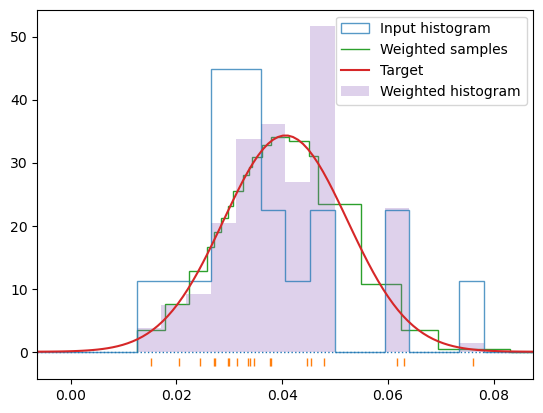

Done. Distribution reshaped to 314.17 K saved to: TMP/DFSET.dat



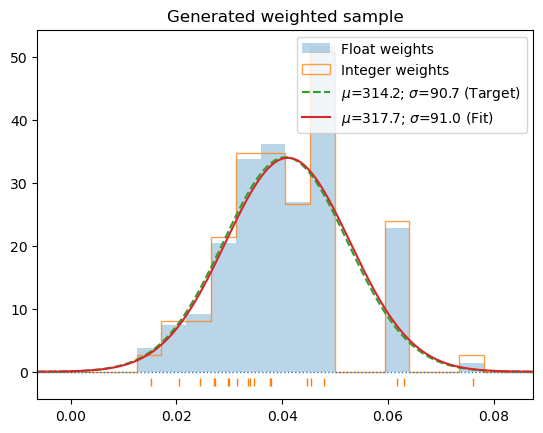

In [ ]:
#| echo: false
!cat TMP/${calc_dir.name}/T_300.0K/DFSET.dat.raw TMP/${calc_dir_2.name}/T_300.0K/DFSET.dat.raw > TMP/DFSET_raw.dat
!rm -f TMP/DFSET.dat
run_cli_cmd(reshape_sample, "--help")
run_cli_cmd(reshape_sample, 
            " -d -o TMP/DFSET.dat"
            " TMP/DFSET_raw.dat")

$ reshape-sample  -d -o TMP/tmpd7jkerzi/T_300.0K/DFSET.dat --check TMP/tmpd7jkerzi/T_300.0K/smpl TMP/tmpd7jkerzi/T_300.0K/DFSET.dat.raw



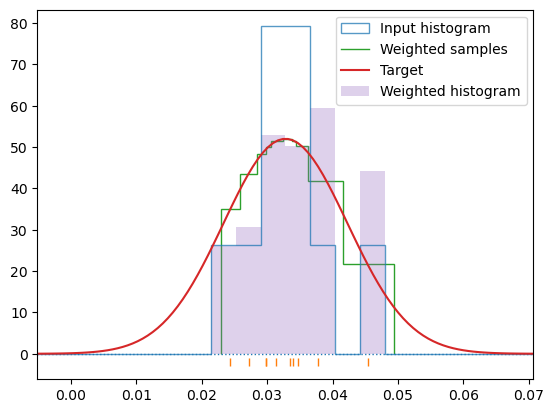

Checking convergence in TMP/tmpd7jkerzi/T_300.0K/smpl/nnnn
Number of converged calculations: 10/10
Done. Distribution reshaped to 253.84 K saved to: TMP/tmpd7jkerzi/T_300.0K/DFSET.dat



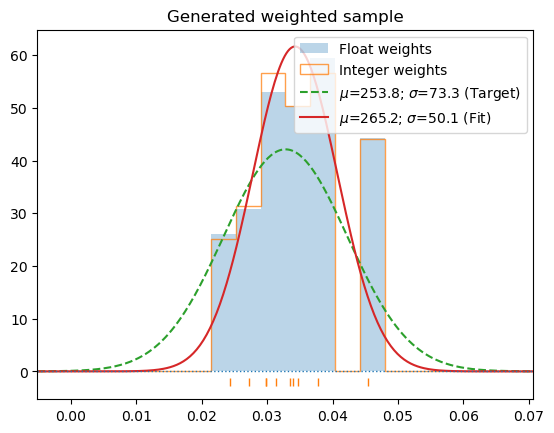

In [ ]:
#| echo: false
#| vasp

!rm -f ${calc_dir.name}/T_300.0K/DFSET.dat
run_cli_cmd(reshape_sample, 
            f" -d -o {calc_dir.name}/T_300.0K/DFSET.dat"
            f" --check {calc_dir.name}/T_300.0K/smpl"
            f" {calc_dir.name}/T_300.0K/DFSET.dat.raw")

## Command line statistics monitoring

This simple command line interface to the statistics plotting function allows for quick monitoring of the running calculation. If the sixelplot package is installed it is even possible to plot hi-res plots in the remote terminal supporting sixel standard (e.g. mlterm, xterm on Linux, iterm2 on OSX).

In [ ]:
#| hide
#| exporti
@click.command()
@click.argument('dfset', type=click.Path(exists=True))
@click.argument('T', default=-1, type=float)
@click.option('-n', '--sqrn', is_flag=True, help='Show sqrt(N) bars on the histogram.')
@click.option('-s', '--sixel', is_flag=True, help='Use SixEl driver for terminal graphics.')
@click.option('-w', '--width', type=float, default=6, help='Width of the figure.')
@click.option('-h', '--height', type=float, default=4, help='Height of the figure.')
@click.option('-o', '--output', type=click.Path(), default="", help='Write output to the file.')
@click.option('-x', is_flag=True, default=False, help='Make plot in an interactive window')
@click.version_option(hecss.__version__, '-V', '--version', message=_version_message)
def plot_stats( dfset, t, output, x, sixel, sqrn, width, height):
    """
    Plot the statistics of the samples from the DFSET file.
    Use T(K) as a reference target temperature. Optionally 
    write out the plot to the output graphics file.
    """
    from hecss.util import load_dfset
    from hecss.monitor import plot_stats
    import matplotlib.pylab as plt

    p = Path(dfset)
    smpl = load_dfset(p)
    plt.figure(figsize=(float(width), float(height)))
    plot_stats(smpl, T=t if t >0 else None, sqrN=sqrn, show=x)
    if output:
        plt.savefig(output)
    if sixel:
        try :
            import sixelplot
        except ImportError:
            print('SixEl graphics support not installed. Install sixelplot package.')
            return
        sixelplot.show()

$ plot-stats --help

Usage: plot-stats [OPTIONS] DFSET [T]

  Plot the statistics of the samples from the DFSET file. Use T(K) as a
  reference target temperature. Optionally  write out the plot to the output
  graphics file.

Options:
  -n, --sqrn          Show sqrt(N) bars on the histogram.
  -s, --sixel         Use SixEl driver for terminal graphics.
  -w, --width FLOAT   Width of the figure.
  -h, --height FLOAT  Height of the figure.
  -o, --output PATH   Write output to the file.
  -x                  Make plot in an interactive window
  -V, --version       Show the version and exit.
  --help              Show this message and exit.

$ plot-stats -n -w 7 -h 4 TMP/DFSET_raw.dat 300




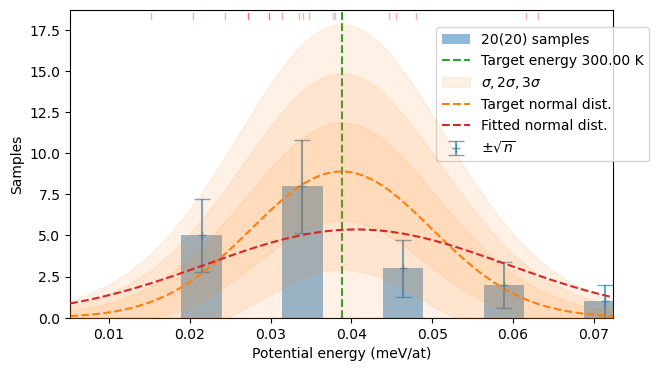

In [ ]:
#| echo: false
#| vasp
#| slow
run_cli_cmd(plot_stats, "--help")

run_cli_cmd(plot_stats, 
            "-n " 
            "-w 7 -h 4 "
            "TMP/DFSET_raw.dat "
            "300")

$ plot-stats -n -w 7 -h 4 TMP/DFSET.dat 




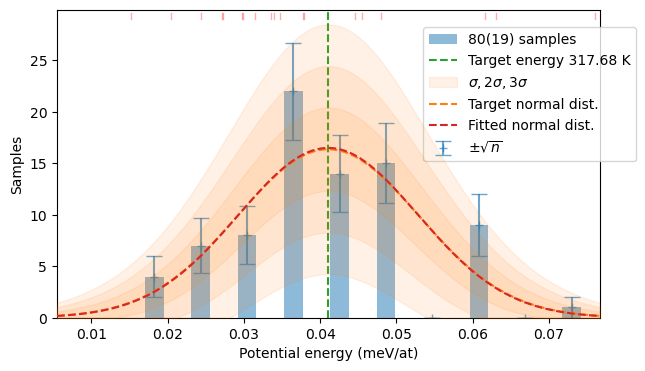

In [ ]:
#| echo: false
#| vasp
#| slow
run_cli_cmd(plot_stats, 
            "-n " 
            "-w 7 -h 4 "
            "TMP/DFSET.dat ")

$ plot-stats -n -w 7 -h 4 example/VASP_3C-SiC_calculated/2x2x2/T_1200K/DFSET.dat 1200




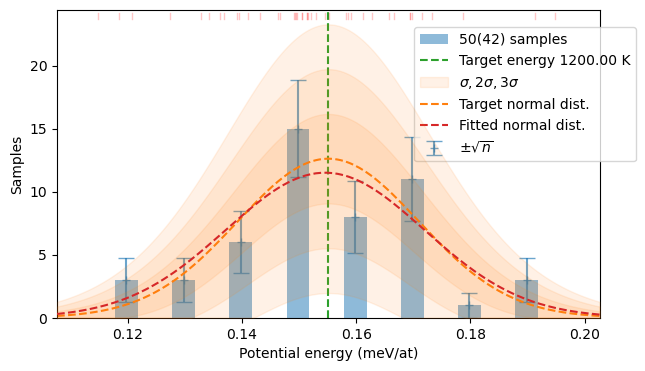

In [ ]:
#| echo: false
run_cli_cmd(plot_stats, 
               "-n " 
               "-w 7 -h 4 "
               "example/VASP_3C-SiC_calculated/2x2x2/T_1200K/DFSET.dat "
               "1200")

## Command line phonon monitoring

This simple command line interface to the phonon plotting function allows for quick monitoring of the phonon calculation. If the sixelplot package is installed it is even possible to plot hi-res plots in the remote terminal supporting sixel standard (e.g. mlterm, xterm on Linux, iterm2 on OSX).

In [ ]:
#| hide
#| exporti
@click.command()
@click.argument('bands', type=click.Path(exists=True), nargs=-1)
@click.option('-s', '--sixel', is_flag=True, help='Use SixEl driver for terminal graphics.')
@click.option('-n', '--nodecor', is_flag=True, help='Decorate the plot.')
@click.option('-w', '--width', type=float, default=6, help='Width of the figure.')
@click.option('-h', '--height', type=float, default=4, help='Height of the figure.')
@click.option('-o', '--output', type=click.Path(), default="", 
              help='Write output to the file.')
@click.option('-l', '--label', type=str, default="", 
              help='Label(s) for the plot. Comma-separated list')
@click.option('-x', is_flag=True, default=False, 
              help='Make plot in an interactive window')
@click.version_option(hecss.__version__, '-V', '--version', message=_version_message)
def plot_bands( bands, output, x, sixel, width, height, label, nodecor):
    """
    Plot the phonon dispersion from the file generated by ALAMODE.
    Optionally write out the plot to the output graphics file.
    """
    import hecss.monitor as hm
    import matplotlib.pylab as plt

    
    plt.figure(figsize=(float(width), float(height)))

    ll = label.split(',')
    if len(ll) < len(bands):
        cp = os.path.commonpath(bands)
        rpl = [p[len(cp):][::-1] for p in bands]
        cs = os.path.commonpath(rpl)
        ll = [p[len(cp):-len(cs)] for p in bands]

    for b, l in zip(bands, ll):
        p = Path(b)

        hm.plot_bands_file(p, lbl=l, decorate=not nodecor)

    if label or len(bands)>1:
        plt.legend()

    if output:
        plt.savefig(output)
    if sixel:
        try :
            import sixelplot
        except ImportError:
            print('SixEl graphics support not installed. Install sixelplot package.')
            return
        sixelplot.show()

$ plot-bands --help

Usage: plot-bands [OPTIONS] [BANDS]...

  Plot the phonon dispersion from the file generated by ALAMODE. Optionally
  write out the plot to the output graphics file.

Options:
  -s, --sixel         Use SixEl driver for terminal graphics.
  -n, --nodecor       Decorate the plot.
  -w, --width FLOAT   Width of the figure.
  -h, --height FLOAT  Height of the figure.
  -o, --output PATH   Write output to the file.
  -l, --label TEXT    Label(s) for the plot. Comma-separated list
  -x                  Make plot in an interactive window
  -V, --version       Show the version and exit.
  --help              Show this message and exit.

$ plot-bands -w 7 -h 4 -l '300K,600K,3000K' example/VASP_3C-SiC_calculated/2x2x2/T_300K/phon/cryst.bands example/VASP_3C-SiC_calculated/2x2x2/T_600K/phon/cryst.bands example/VASP_3C-SiC_calculated/2x2x2/T_3000K/phon/cryst.bands 




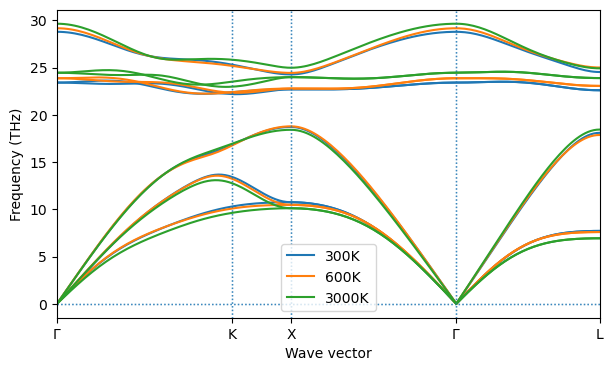

In [ ]:
#| echo: false
run_cli_cmd(plot_bands, "--help")
run_cli_cmd(plot_bands, 
               "-w 7 -h 4 -l '300K,600K,3000K' "
               "example/VASP_3C-SiC_calculated/2x2x2/T_300K/phon/cryst.bands "
               "example/VASP_3C-SiC_calculated/2x2x2/T_600K/phon/cryst.bands "
               "example/VASP_3C-SiC_calculated/2x2x2/T_3000K/phon/cryst.bands ")

In [ ]:
#|hide
#|vasp
#|eval: false
CLEANUP=False

In [ ]:
#|hide
#|vasp
try :
    CLEANUP
except NameError:
    calc_dir.cleanup()
    calc_dir_2.cleanup()